In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from flatten_json import flatten
from copy import deepcopy

import utils
from models import PostSequenceDataset
import os
from os.path import join
import shutil
import json
from operator import itemgetter
from itertools import islice
from glob import glob

pd.set_option("max.columns", None)

In [2]:
data_dir = "/data/misinformation-domains/final/with-cls"
art_conts_dir = join(data_dir, "articles")
shared_articles_tw_path = join(data_dir, "../shared-articles-in-tweet.csv")
shared_articles_fb_path = join(data_dir, "../shared-articles-in-fb-post.csv")
tweets_dir = join(data_dir, "tweets")
fb_posts_dir = join(data_dir, "fb_posts")
tw_users_dir = join(data_dir, "tw_users")
fb_acc_dir = join(data_dir, "fb_accs")
ground_truth_path = "../resources/domains/clean/domain_list_clean.csv"

shared_articles_tw = pd.read_csv(shared_articles_tw_path, dtype={"tweet_id": str, "author_id": str}) \
    .add_prefix("shared_art|")
shared_articles_fb = pd.read_csv(shared_articles_fb_path, dtype={"post_id": str, "account.id": str}) \
    .add_prefix("shared_art|")
gt_labels = pd.read_csv(ground_truth_path, dtype=str) \
    .drop(columns=["label", "source", "last_update"]) \
    .add_prefix("gt|")
for col in ["gt|accuracy", "gt|transparency", "gt|type", "gt|accuracy_bin"]:
    gt_labels[col + "_enc"] = LabelEncoder().fit_transform(gt_labels[col])

with open(join(art_conts_dir, "index.json")) as f:
    available_sources = [k.split("=")[-1] for k in json.load(f).keys()]
gt_labels = gt_labels[gt_labels["gt|url"].isin(available_sources)].sort_values(by="gt|url")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
subdir_name = "220315-2231"
checkpoint_dir = join("/data/misinformation-domains/train_checkpoints", subdir_name)
last_epoch_path = sorted(glob(join(checkpoint_dir, "model-state-epoch-*.pt")))[-1]
checkpoint = torch.load(last_epoch_path, map_location=device)
with open(join(checkpoint_dir, "config.json")) as f:
    config = json.load(f)
config

{'seed': 19,
 'label': 'transparency',
 'oversampling': True,
 'n_epochs': 3,
 'batch_size': 16,
 'loss_fn': 'CrossEntropyLoss',
 'optimizer': {'name': 'Adam', 'lr': 0.0001},
 'psm': {'type': 'LSTM', 'hidden_size': 1000, 'output': 'mean'},
 'te': {'type': 'mean', 'embedding_size': None}}

In [4]:
label_col = f"gt|{config['label']}_enc"
dataset = PostSequenceDataset(gt_labels, label_col, shared_articles_tw, shared_articles_fb, art_conts_dir, tweets_dir, fb_posts_dir, tw_users_dir, fb_acc_dir, has_cls_enc=True)

trainset = dataset.gt_labels.set_index("gt|url").loc[list(sum(checkpoint["urls"], ()))]
classes = dataset.get_classes()
classes = [str(c) for c in classes]
classes

['1', '2', '3']

In [5]:
def get_seq_len(urls):
    urls_series = pd.Series(urls).rename("shared_art|queried_url")
    return pd.concat([shared_articles_tw.merge(urls_series), shared_articles_fb.merge(urls_series)]) \
        .groupby("shared_art|queried_url").count()["shared_art|article_id"].loc[urls].tolist()

seq_lens = get_seq_len(trainset.index.tolist())
seq_len_df = pd.Series(seq_lens, name="sequence length").reset_index()
seq_len_df["label"] = [classes[l] for l in trainset[label_col]]

In [6]:
def get_nunique_docs(urls):
    urls_series = pd.Series(urls).rename("shared_art|queried_url")
    nunique_docs = pd.concat([shared_articles_tw.merge(urls_series), shared_articles_fb.merge(urls_series)]) \
        .groupby("shared_art|queried_url").nunique().loc[urls]
    nunique_docs["nunique_posts"] = nunique_docs[["shared_art|tweet_id", "shared_art|post_id"]].sum(axis=1)
    nunique_docs["nunique_users"] = nunique_docs[["shared_art|author_id", "shared_art|account.id"]].sum(axis=1)
    return nunique_docs.rename(columns={"shared_art|article_id": "nunique_articles"})[["nunique_articles", "nunique_posts", "nunique_users"]].reset_index(drop=True).reset_index()

nunique_docs = get_nunique_docs(trainset.index.tolist())
nunique_docs = nunique_docs.melt(id_vars="index", var_name="doc", value_name="nunique").merge(seq_len_df, how="left")
nunique_docs["unique_ratio"] = nunique_docs["nunique"] / nunique_docs["sequence length"]

# Model Training Analysis

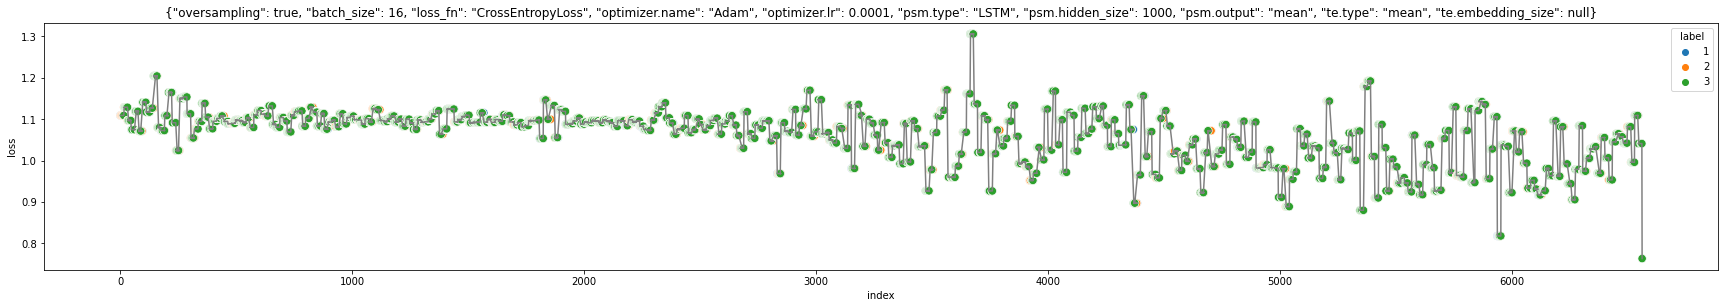

In [7]:
plot_title = json.dumps(flatten(config, separator=".", root_keys_to_ignore=["label", "n_epochs", "seed"]))
palette = {"inaccurate": "#b2182b", "accurate": "#2166ac"} if label_col.endswith("_bin_enc") else None
fig = plt.figure(figsize=(30, 10))
ax0 = fig.add_subplot(2, 1, 1)
if label_col.endswith("_bin_enc") and config["batch_size"] > 1:
    loss_df = pd.Series([classes[l] for l in trainset[label_col]], name="label").reset_index()
    loss_df["batch_id"] = loss_df["index"] // config["batch_size"]
    loss_df = loss_df.groupby(["batch_id", "label"]).count().reset_index().rename(columns={"index": "count"}) \
        .merge(loss_df.groupby("batch_id")["label"].apply(lambda labels: max(labels.tolist(), key=lambda l: labels.tolist().count(l))).reset_index(), on=["batch_id", "label"]) \
        .merge(pd.Series(checkpoint["losses"], name="loss").reset_index(), left_on="batch_id", right_on="index").drop(columns=["index"])
    loss_df["div_count"] = np.where(loss_df["label"] == "inaccurate", -1 * loss_df["count"], loss_df["count"])
    
    if config["batch_size"] == 2:
        sns.scatterplot(data=loss_df, x="batch_id", y="loss", hue="div_count", s=70, palette="RdBu", ax=ax0).set(title=plot_title)
        ax0.legend(title="Label count")
    else:
        sns.scatterplot(data=loss_df, x="batch_id", y="loss", hue="div_count", size="count", sizes=(50, 200), palette="RdBu", ax=ax0).set(title=plot_title)
        new_labels = {"div_count": "Label count", "count": "Absolute count"}
        for t in ax0.get_legend().texts:
            if t.get_text() in new_labels:
                t.set_text(new_labels[t.get_text()])

    ax0.plot(loss_df["batch_id"], loss_df["loss"], color='grey')
else:
    loss_df = pd.Series(np.repeat(checkpoint["losses"], config["batch_size"]), name="loss").reset_index()
    loss_df = loss_df.iloc[:torch.cat(checkpoint["outputs"]).shape[0]]
    loss_df["label"] = [classes[l] for l in trainset[label_col]]
    loss_df["batch_id"] = loss_df["index"] // config["batch_size"]
    loss_df = loss_df.sort_values(by=["batch_id", "label"])
    sns.scatterplot(data=loss_df, x="index", y="loss", hue="label", hue_order=classes, s=70, palette=palette, ax=ax0).set(title=plot_title)
    ax0.plot(loss_df["index"], loss_df["loss"], color='grey')

In [8]:
output_df = pd.DataFrame(torch.cat(checkpoint["outputs"]).tolist(), columns=classes) \
    .reset_index().melt(id_vars=["index"], value_vars=classes, var_name="class", value_name="output")
ax = fig.add_subplot(2, 1, 2)
sns.lineplot(data=output_df, x="index", y="output", hue="class", palette=palette, ax=ax)

<AxesSubplot:xlabel='index', ylabel='output'>

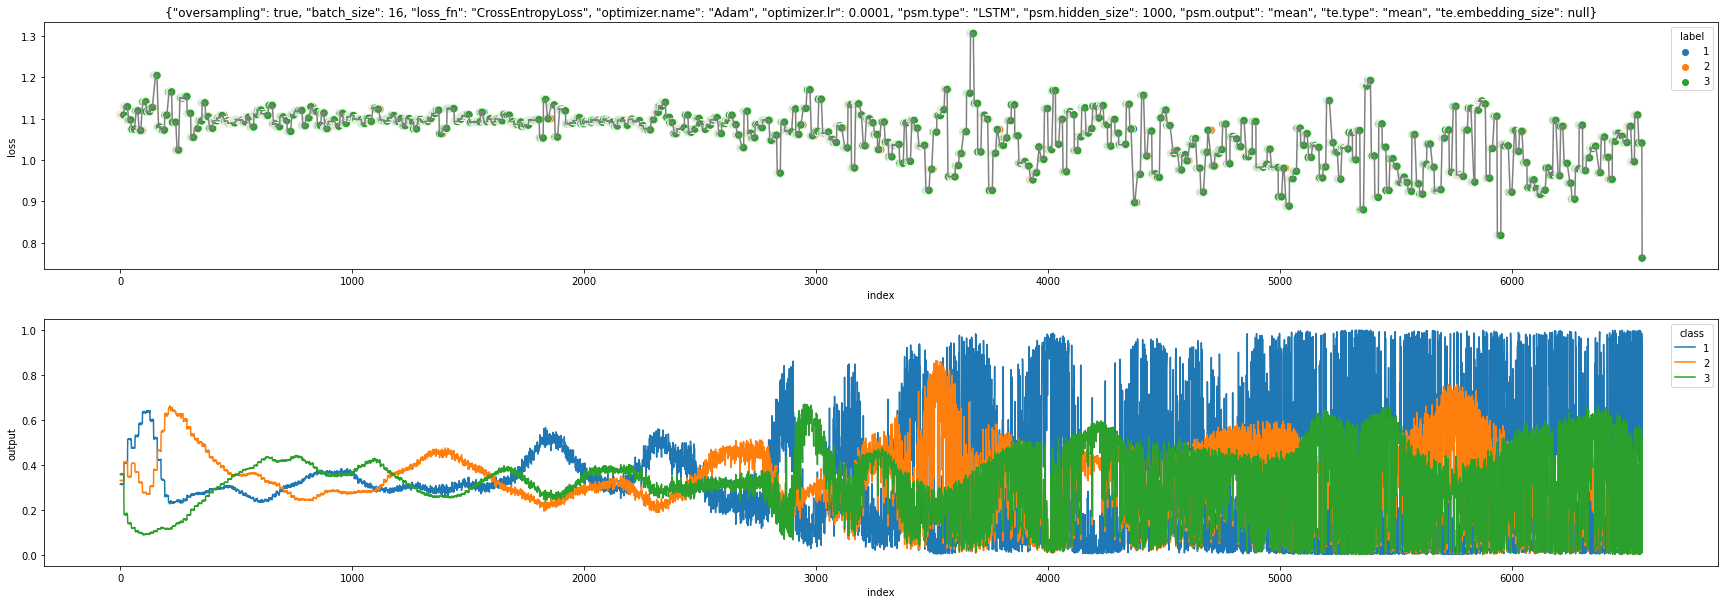

In [9]:
fig.savefig(join(checkpoint_dir, "model-output.png"), facecolor="white", transparent=True, bbox_inches="tight")
fig.savefig(join(checkpoint_dir, "model-output.pdf"), facecolor="white", transparent=True, bbox_inches="tight")
fig

Text(0.5, 1.0, '{"oversampling": true, "batch_size": 1, "loss_fn": "CrossEntropyLoss", "optimizer.name": "SGD", "optimizer.lr": 0.1, "optimizer.momentum": 0.9, "psm.type": "LSTM", "psm.hidden_size": 1000, "psm.output": "last_state", "te.type": "mean", "te.embedding_size": null}')

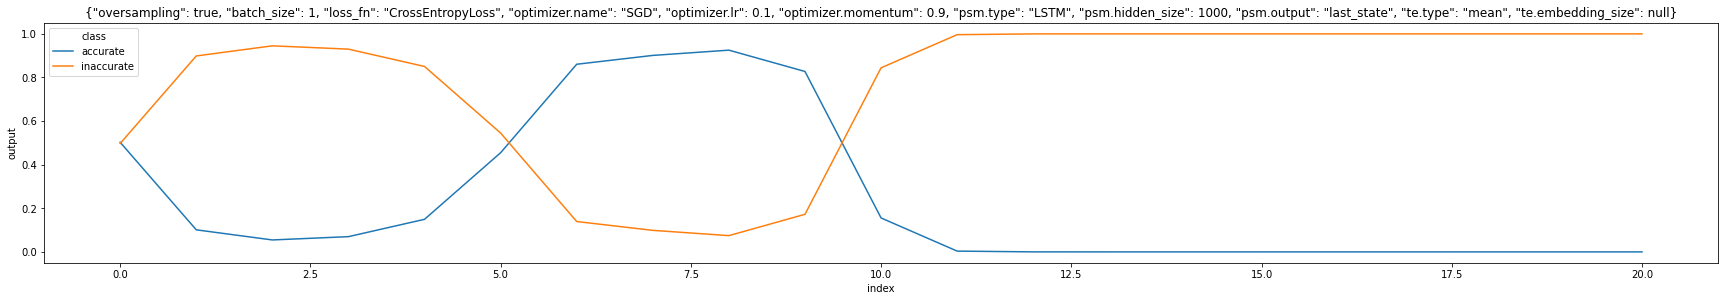

In [ ]:
idx = 0, 20 #torch.cat(checkpoint["outputs"]).shape[0]
fig = plt.figure(figsize=(30, 15))
ax0 = fig.add_subplot(3, 1, 1)
sns.lineplot(data=output_df.query(f"index >= {idx[0]} & index <= {idx[1]}"), x="index", y="output", hue="class", ax=ax0)
ax0.set_title(plot_title)

In [ ]:
seq_len_df_filt = seq_len_df.query(f"index >= {idx[0]} & index <= {idx[1]}")
ax = fig.add_subplot(3, 1, 2, sharex=ax0)
sns.scatterplot(data=seq_len_df_filt, x="index", y="sequence length", hue="label", hue_order=classes, s=70, ax=ax)
ax.plot(seq_len_df_filt["index"], seq_len_df_filt["sequence length"], color='grey')

In [ ]:
nunique_docs_filt = nunique_docs.query(f"index >= {idx[0]} & index <= {idx[1]}")
ax = fig.add_subplot(3, 1, 3, sharex=ax0)
sns.scatterplot(data=nunique_docs_filt, x="index", y="unique_ratio", hue="label", hue_order=classes, s=70, ax=ax)
sns.lineplot(data=nunique_docs_filt, x="index", y="unique_ratio", style="doc", ax=ax)

<AxesSubplot:xlabel='index', ylabel='unique_ratio'>

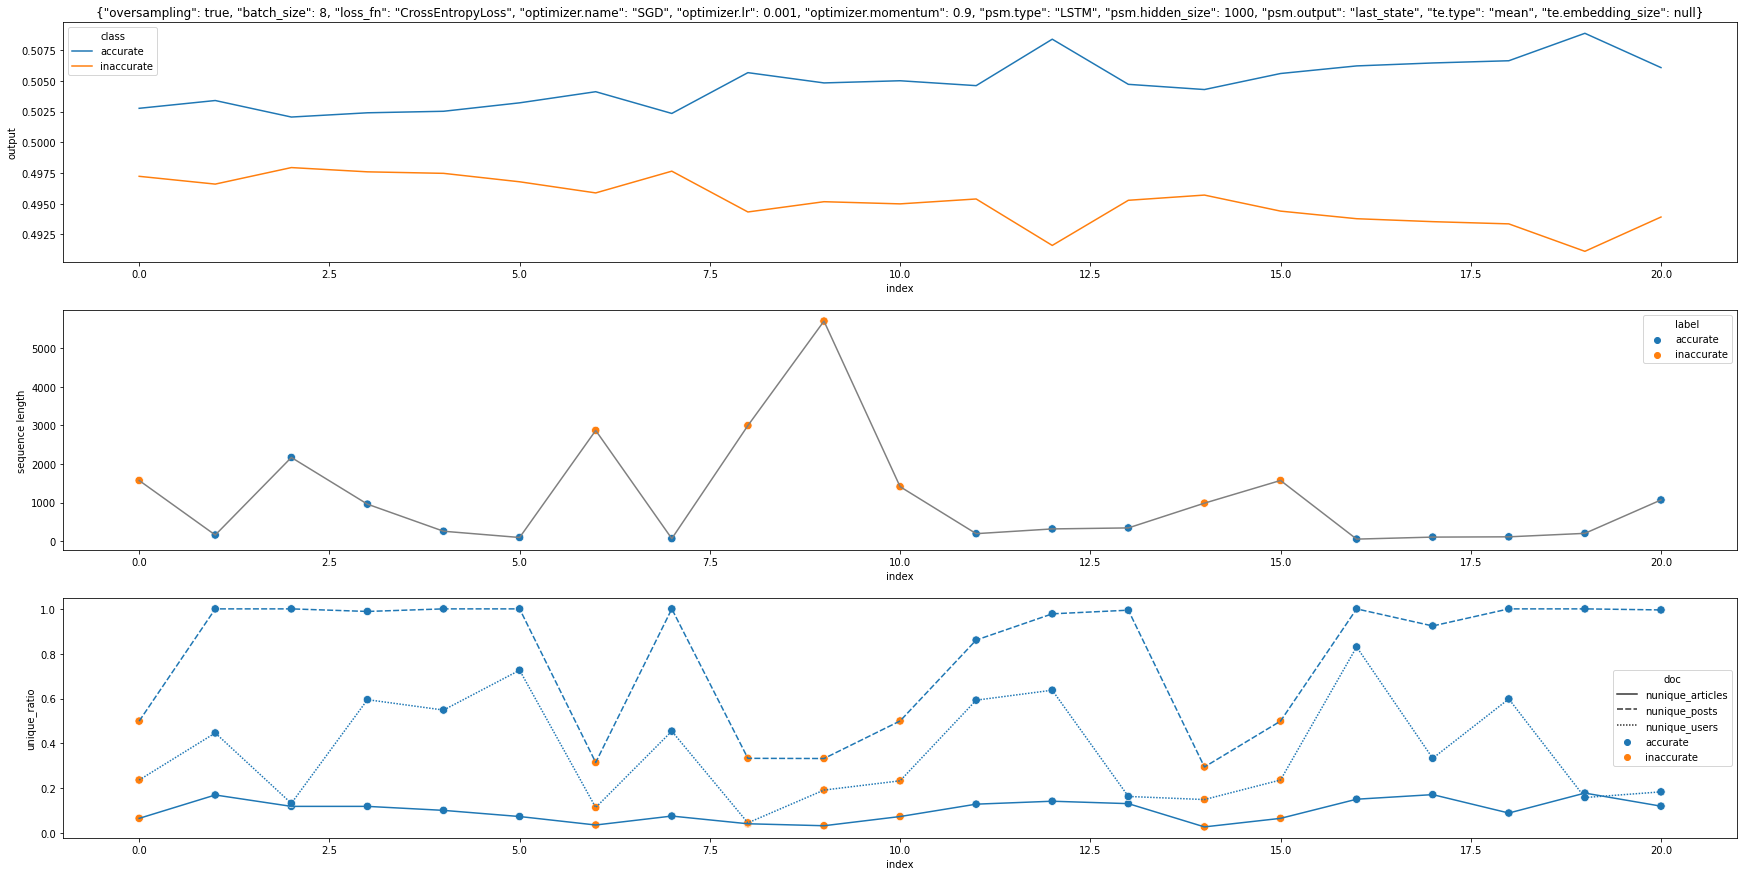

In [ ]:
fig.savefig(join(checkpoint_dir, f"model-out-loss{idx[0]}-{idx[1]}.png"), facecolor="white", transparent=False)
fig

# All Learning Curves

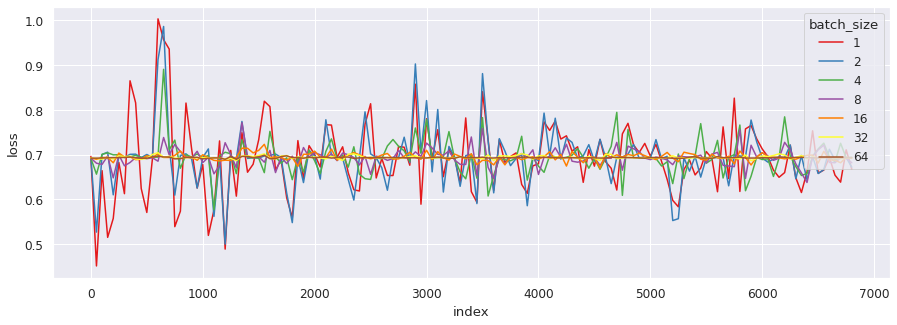

In [14]:
base_dir = "/data/misinformation-domains/train_checkpoints/oversampling"
_, subdirs, _ = next(os.walk(base_dir))
if len(subdirs) == 0:
    subdirs.append(base_dir)
losses = []
for i, subdir in enumerate(subdirs):
    last_epoch_path = sorted(glob(join(base_dir, subdir, "model-state-epoch-*.pt")))[-1]
    checkpoint = torch.load(last_epoch_path, map_location=device)
    with open(join(base_dir, subdir, "config.json")) as f:
        config = json.load(f)

    loss_df = pd.Series(np.repeat(checkpoint["losses"], config["batch_size"]), name="loss").reset_index()
    loss_df = loss_df.iloc[:torch.cat(checkpoint["outputs"]).shape[0]]
    loss_df["batch_size"] = config["batch_size"]
    losses.append(loss_df)

with open(join(base_dir, "base_config.json")) as f:
    config = json.load(f)
del config["psm"]["type"], config["psm"]["hidden_size"]
plt.figure(figsize=(15, 5))
sns.set(font_scale = 1.1)
sns.lineplot(data=pd.concat(losses).query("index % 50 == 0"), x="index", y="loss", hue="batch_size", palette="Set1")
# plt.title(json.dumps(flatten(config, separator=".", root_keys_to_ignore=["label", "n_epochs", "seed", "batch_size", "loss_fn", "psm.type", "psm.hidden_size", "te"])), fontsize=16)
plt.savefig(join(join(base_dir, "losses.png")), facecolor="white", transparent=True, bbox_inches="tight")
plt.savefig(join(join(base_dir, "losses.pdf")), facecolor="white", transparent=True, bbox_inches="tight")

# Testing

In [3]:
base_dir = "/data/misinformation-domains/train_checkpoints/Adam-psm-out"
_, subdirs, _ = next(os.walk(base_dir))
if len(subdirs) == 0:
    subdirs.append(base_dir)
test_name = "test"
evals = []
for subdir in subdirs:
    if os.path.exists(join(base_dir, subdir, f"pred-{test_name}.csv")):
        with open(join(base_dir, subdir, "config.json")) as f:
            config = json.load(f)

        label = config["label"]
        classes = sorted(gt_labels[f"gt|{label}"].unique())
        preds = pd.read_csv(join(base_dir, subdir, f"pred-{test_name}.csv")) \
            .replace(dict(enumerate(classes)))
        report = metrics.classification_report(preds[f"{label}_true"], preds[f"{label}_pred"], zero_division=0, output_dict=True)
        eval = {"conf": deepcopy(flatten(config)), ("total", "accuracy"): report["accuracy"], ("total", "macro f1"): report["macro avg"]["f1-score"]}
        for c in classes:
            eval[(c, "# pred")] = preds[f"{label}_pred"].value_counts().to_dict().get(c, 0)
            eval[(c, "# true")] = preds[f"{label}_true"].value_counts().to_dict().get(c, 0)
            if c == "accurate" and False:
                eval[(c, "recall")] = report[c]["recall"]
            elif c == "inaccurate" and False:
                eval[(c, "precision")] = report[c]["precision"]
            else:
                eval[(c, "precision")] = report[c]["precision"]
                eval[(c, "recall")] = report[c]["recall"]
                eval[(c, "f1")] = report[c]["f1-score"]
        evals.append(eval)

diff_keys = []
for key in evals[0]["conf"].keys():
    if len(set([e["conf"][key] for e in evals])) > 1:
        diff_keys.append(key.replace("_", " "))
        for e in evals:
            e[key.replace("_", " ")] = e["conf"][key]

In [7]:
eval = pd.DataFrame(evals).drop(columns=["conf"])
if len(diff_keys) > 0:
    eval = eval.set_index(diff_keys)
eval = eval.sort_index()
eval.rename(columns={c: " ".join(c) if c[1] != "" else c[0] for c in eval.columns}).to_csv(join(base_dir, f"scores-{test_name}.csv"))
eval.columns = pd.MultiIndex.from_tuples(eval.columns)
eval#.sort_values(by=("total", "macro f1"), ascending=False)

total           accurate                                       \
            accuracy  macro f1   # pred # true precision    recall        f1   
batch size                                                                     
16          0.837563  0.769591      161    143   0.84472  0.951049  0.894737   
32          0.837563  0.785578      151    143   0.86755  0.916084  0.891156   

           inaccurate                                       
               # pred # true precision    recall        f1  
batch size                                                  
16                 36     54  0.805556  0.537037  0.644444  
32                 46     54  0.739130  0.629630  0.680000

In [8]:
with open(join(base_dir, f"scores-{test_name}.tex"), "w") as f:
    f.write(eval.to_latex(float_format="%.3f", column_format="|" + (eval.index.nlevels * "p{1cm}") + "|rr|rrrrr|rrrrr|", multicolumn_format="c|", bold_rows=True) \
        .replace("{total}", "{\\textbf{total}}").replace("{accurate}", "{\\textbf{accurate}}").replace("{inaccurate}", "{\\textbf{inaccurate}}"))

In [72]:
for subdir in subdirs:
    with open(join(base_dir, subdir, "config.json")) as f:
        config = json.load(f)

    if config["batch_size"] == 32 and config["psm"]["output"] == "mean":
        classes = ["accurate", "inaccurate"]
        preds = pd.read_csv(join(base_dir, subdir, f"pred-{test_name}.csv")) \
            .replace(dict(enumerate(classes)))
        report = metrics.classification_report(preds[f'{config["label"]}_true'], preds[f'{config["label"]}_pred'], zero_division=0, output_dict=True)
        break

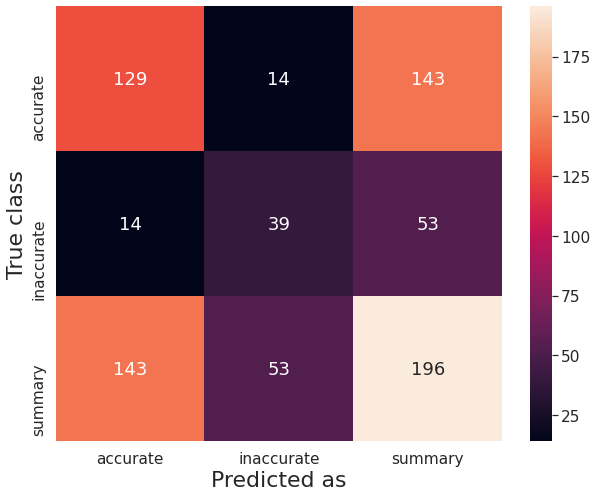

In [73]:
cf_matrix = metrics.confusion_matrix(preds[f'{config["label"]}_true'], preds[f'{config["label"]}_pred'])
summary_cf_matrix = np.vstack([cf_matrix, np.sum(cf_matrix, axis=0)])
summary_cf_matrix = np.hstack([summary_cf_matrix, np.sum(summary_cf_matrix, axis=1, keepdims=True)])
#  / np.sum(cf_matrix) * 100 for normalization
df_cm = pd.DataFrame(summary_cf_matrix, index=classes + ["summary"], columns=classes + ["summary"]).round(2)

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, fmt=".4g", annot_kws={"fontsize": 18})

plt.xlabel("Predicted as", fontsize=22)
plt.ylabel("True class", fontsize=22)
plt.savefig(join(base_dir, f'confusion-matrix-{config["batch_size"]}.pdf'), facecolor="white", transparent=True, bbox_inches="tight")
plt.show()

## Copy images in parent directory

In [80]:
base_dir = "/data/misinformation-domains/train_checkpoints/bs16"
_, subdirs, _ = next(os.walk(base_dir))
for subdir in subdirs:
    shutil.copy(join(base_dir, subdir, "model-output.png"), join(base_dir, f"{subdir}.png"))
    shutil.copy(join(base_dir, subdir, "model-output.pdf"), join(base_dir, f"{subdir}.pdf"))

In [76]:
base_dir = "/data/misinformation-domains/train_checkpoints"
_, subdirs, _ = next(os.walk("/data/misinformation-domains/train_checkpoints"))
for subdir in subdirs:
    if subdir != "old-split":
        shutil.copy(join(base_dir, subdir, "scores-val.csv"), join(base_dir, f"scores-val-{subdir}.csv"))
        if os.path.exists(join(base_dir, subdir, "scores-val.tex")):
            shutil.copy(join(base_dir, subdir, "scores-val.tex"), join(base_dir, f"scores-val-{subdir}.tex"))

FileNotFoundError: [Errno 2] No such file or directory: '/data/misinformation-domains/train_checkpoints/Adam-psm-out/scores-val.csv'

# Analyze Train Configs

In [5]:
def conf_diff(base_dir):
    _, subdirs, _ = next(os.walk(base_dir))
    confs = []
    for subdir in sorted(subdirs):
        if os.path.exists(join(base_dir, subdir, "config.json")):
            with open(join(base_dir, subdir, "config.json")) as f:
                confs.append(flatten(json.load(f), separator="."))
    df = pd.DataFrame(confs)
    return df.loc[:, df.apply(pd.Series.nunique) > 1]

In [6]:
conf_diff("/data/misinformation-domains/train_checkpoints/cv-bin-oversampling")

,seed,label,oversampling,n_epochs,batch_size,loss_fn,optimizer.name,optimizer.lr,psm.type,psm.hidden_size,psm.output,te.type,te.embedding_size
0,19,accuracy_bin,True,3,16,CrossEntropyLoss,Adam,0.0001,LSTM,1000,mean,mean,None
1,19,accuracy_bin,True,3,16,CrossEntropyLoss,Adam,0.0001,LSTM,1000,mean,mean,None
2,19,accuracy_bin,True,3,16,CrossEntropyLoss,Adam,0.0001,LSTM,1000,mean,mean,None
3,19,accuracy_bin,True,3,16,CrossEntropyLoss,Adam,0.0001,LSTM,1000,mean,mean,None
4,19,accuracy_bin,True,3,16,CrossEntropyLoss,Adam,0.0001,LSTM,1000,mean,mean,None
5,19,accuracy_bin,True,3,16,CrossEntropyLoss,Adam,0.0001,LSTM,1000,mean,mean,None
6,19,accuracy_bin,True,3,16,CrossEntropyLoss,Adam,0.0001,LSTM,1000,mean,mean,None
7,19,accuracy_bin,True,3,16,CrossEntropyLoss,Adam,0.0001,LSTM,1000,mean,mean,None
8,19,accuracy_bin,True,3,16,CrossEntropyLoss,Adam,0.0001,LSTM,1000,mean,mean,None
9,19,accuracy_bin,True,3,16,CrossEntropyLoss,Adam,0.0001,LSTM,1000,mean,mean,None


In [69]:
conf_diff("/data/misinformation-domains/train_checkpoints/bs4")

,optimizer.lr,optimizer.momentum
0,0.0010,0.0
1,0.0010,0.5
2,0.0010,0.9
3,0.0001,0.0
4,0.0001,0.5
5,0.0001,0.9
6,0.0100,0.5
7,0.0100,0.9
8,0.0100,0.0


# Tensorboard

In [ ]:
writer = SummaryWriter(checkpoint_dir)

In [ ]:
# Write loss
for i, loss in enumerate(checkpoint["losses"]):
    writer.add_scalar("loss", loss, global_step=i * config["batch_size"])

In [ ]:
# Write outputs, labels, and sequence lengths
for i, (output_row, label, seq_len, unique_ratio) in enumerate(zip(torch.cat(checkpoint["outputs"]), trainset[label_col].tolist(), seq_lens, 
    nunique_docs.groupby("index").agg({"doc": list, "unique_ratio": list}).apply(lambda row: dict(zip(row["doc"], row["unique_ratio"])), axis=1).tolist())):
    
    writer.add_scalars("output", {classes[j]: out for j, out in enumerate(output_row.tolist())}, global_step=i)
    writer.add_scalar("label", label, global_step=i)
    writer.add_scalar("sequence length", seq_len, global_step=i)
    writer.add_scalars("unique ratio", unique_ratio, global_step=i)

In [ ]:
# Write PR Curves
probs = torch.cat(checkpoint["outputs"])
labels = torch.as_tensor(trainset[label_col])
for i, c in enumerate(classes):
    writer.add_pr_curve(c, labels == i, probs[:, i], global_step=0)

In [ ]:
# Plot Probs against labels
for i, (output_row, label) in tqdm(enumerate(zip(torch.cat(checkpoint["outputs"]), trainset[label_col].tolist())), total=trainset.shape[0]):
    fig = plt.figure()
    sns.barplot(x=classes, y=output_row.tolist()).set(title=f"Actual: {classes[label]}")
    writer.add_figure("predictions vs. actual", fig, global_step=i)

  0%|          | 0/1166 [00:00<?, ?it/s]

In [ ]:
writer.flush()
writer.close()

# GC Analysis

In [ ]:
# diff = utils.gc_diff(checkpoint["gc_objs"])
# pd.DataFrame(diff).explode("removed", ignore_index=True).explode("added", ignore_index=True)